In [1]:
import numpy as np
import torch
import torchvision
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


In [2]:
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        super().__init__()
        self.dataset = dataset
        self.transform = transform
        
        
    def __getitem__(self, n):
        data = self.dataset[n]
        return self.transform(data[0]), data[1]
    
    def __len__(self):
        return len(self.dataset)
        

In [3]:
folder = r'C:\Users\chtti\Downloads\拍照簽收圖檔-20211027T020311Z-001\拍照簽收圖檔'
BATCH_SIZE = 32

train_transform = T.Compose([
    T.AutoAugment(T.autoaugment.AutoAugmentPolicy.IMAGENET),
    T.Resize((540, 540)),
    T.ToTensor()
])
val_transform = T.Compose([
    T.Resize((540, 540)),
    T.ToTensor()
])

dataset = ImageFolder(folder)

train_length = int(len(dataset) * 0.8)
val_length = len(dataset) - train_length
train_set, val_set = random_split(dataset, [train_length, val_length], torch.Generator().manual_seed(42))
train_set_aug = TransformDataset(train_set, train_transform)
val_set_trans = TransformDataset(val_set, val_transform)

train_loader = DataLoader(train_set_aug, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set_trans, batch_size=8)

In [4]:
len(dataset)

1006

In [5]:
dataset.classes

['bad', 'good']

In [6]:
train_set[0]

(<PIL.Image.Image image mode=RGB size=1080x1920 at 0x1F8163AC4F0>, 0)

In [7]:
# next(iter(train_loader))

In [8]:
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams['figure.figsize'] = [24, 8]


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0])


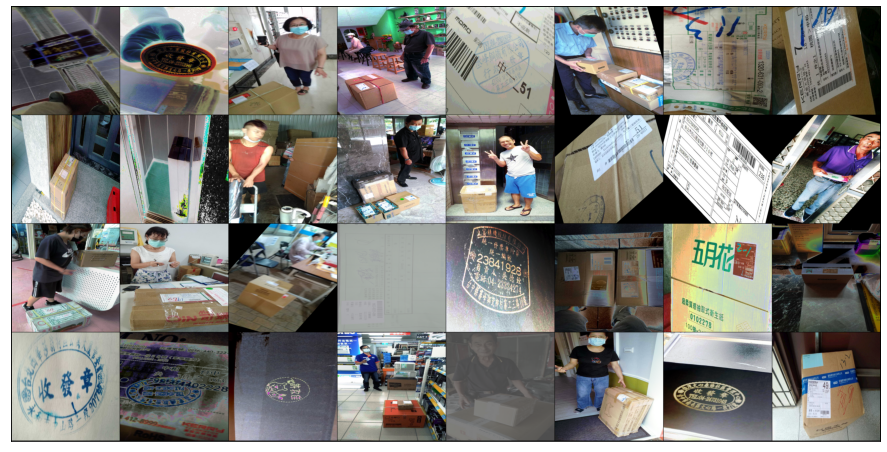

In [9]:
sample = next(iter(train_loader))
grid = make_grid(sample[0])
show(grid)
print(sample[1])

torch.Size([8, 3, 540, 540])
tensor([1, 1, 0, 1, 0, 1, 1, 0])


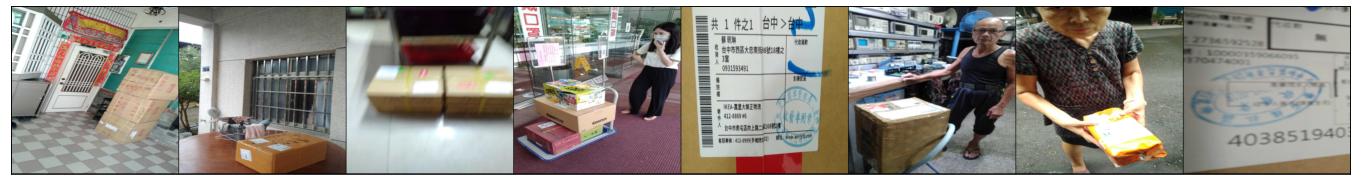

In [10]:
sample = next(iter(val_loader))
print(sample[0].shape)
grid = make_grid(sample[0])
show(grid)
print(sample[1])

In [11]:
resnet34 = torchvision.models.resnet34(pretrained=True)

In [12]:
net = torchvision.models.resnet34(num_classes=2)

In [13]:
d = resnet34.state_dict()
del d['fc.weight']
del d['fc.bias']

net.load_state_dict(d, strict=False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = net.to(device)
loss = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters())

In [16]:
MAX_EPOCH = 1000
MAX_BATCH = BATCH_SIZE * MAX_EPOCH

data_iter = iter(train_loader)
for batch in range(MAX_BATCH):
    data, label = next(data_iter)
    data = data.to(device)
    label = label.to(device)
    break
    